In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

In [2]:
#Funzione media pesata
def weighted_mean (x, w):
    return (np.sum(x*w))/ (np.sum(w))

In [3]:
#Funzioni Residui Lineari
def res_lin (x, y, E_m, E_c, w, verbose=True):
    if (verbose):
        for i in range (0, len(y)):
            print ('e_{:} = {:}\n'.format(i+1, (y[i] - E_m*x[i] - E_c)/w[i]) )
        return (y - E_m*x - E_c)/w
    else:
        return (y - E_m*x - E_c)/w
    
def chi2_lin (x, y, E_m, E_c, w):
    return np.sum( ( (y - E_m*x - E_c)/w )**2 )

def y_lin(x, m, c):
    return (m*x+c)

def y_unc(xP, u_m, u_c, cov_mc):
    return np.sqrt(np.power(xP, 2)*np.power(u_m, 2) +
                   np.power(u_c, 2) + 2*xP*cov_mc )

def verify_seq(w_x, w_y, m):
    Y = w_y
    X = (m*w_x)
    print ('X : \n', X, '\nY : \n', Y, '\n')
    operation = False
    for i in range (0, len(Y)):
        if (X[i] >= 0.1*Y[i]):
            temp_s_eq = np.sqrt(Y**2+X**2)
            operation = True
    if (operation == True):
        print ('S_eq = {:.4}'.format(temp_s_eq))
        S_EQ = temp_seq
        return S_EQ
    else:
        print ('Non è necessario reiterare la sigma')
        return w_y

def s_th (x, y, E_m, E_c) :
    s = np.sqrt( np.sum( (y-E_m*x-E_c)**2 )/ (len(y)-2))
    print ('S_th ={:.5}'.format(s))
    return s
def errore_sistematico (u_calc, u_th):
    E = np.sqrt(np.abs(u_calc**2-u_th**2))
    print ('Errore sistematico :\n', E)
    return E

In [4]:
def Linear_Fit (x, y, w, verbose_1=False, verbose_2=False, verbose_res = False, verbose_fit=True):
    
    # Per il fit lineare si utilizzano i pesi quadratici, 
    # ma è più veloce calcolarli una sola volta e pesarli già al quadrato
    
    #sums (1/w^2)
    w2_y = np.power(w, -2)
    sum_s_w = np.sum (w2_y)
    
    #valori pesati
    x_w  = weighted_mean (x, w2_y)
    y_w  = weighted_mean (y, w2_y)
    xy_w = weighted_mean (x*y, w2_y)
    x2_w = weighted_mean (x*x, w2_y) 
    # Stampa: Oggetti base
    if (verbose_1):
        print ('s_tot = {:}\n'.format(np.sqrt(1/sum_s_w))+
               'x_w = {:}\n'.format(x_w)+
               'y_w = {:}\n'.format(y_w)+
               'xy_w = {:}\n'.format(xy_w)+
               'x2_w = {:}\n'.format(x2_w))
            
    #varianza e covarianza pesata
    wvar_x  = x2_w - (x_w**2)
    wcov_xy = xy_w - x_w*y_w 
    # Stampa: Varianze "Pesate"
    if (verbose_2):
        print ('wVAR_x = {:}\n'.format(wvar_x)+
               'wCOV_xy = {:}\n'.format(wcov_xy))
    #m
    E_m = wcov_xy/wvar_x
    VAR_m = 1/(sum_s_w * wvar_x)
    U_m = np.sqrt(VAR_m)
    #c
    E_c = y_w - E_m * x_w
    VAR_c = (x2_w)/(sum_s_w * wvar_x)
    U_c = np.sqrt(VAR_c)
    #COV[m,c]
    COV_mc = -x_w/(sum_s_w * wvar_x)
    #chi2
    chi2 = chi2_lin(x, y, E_m, E_c, w)  
    #rho
    rho_mc = COV_mc / (U_m * U_c)
    #residui
    if (verbose_res):
        res = res_lin (x, y, E_m, E_c, w, verbose=True)
    else:
        res = res_lin (x, y, E_m, E_c, w, verbose=False)        
    # Stampa: "Risultati fit"
    if (verbose_fit):
        print ('E_m = {:.4}'.format(E_m)+'\n'+
               'VAR_m = {:.4}'.format(VAR_m)+'\n'+
               'U_m = {:.4}'.format(U_m)+'\n'+
               'E_c = {:.4}'.format(E_c)+'\n'+
               'VAR_c = {:.4}'.format(VAR_c)+'\n'+
               'U_c = {:.4}'.format(U_c)+'\n'+
               'chi2 = {:.4}'.format(chi2)+'\n'
               'rho_mc = {:.4}'.format(rho_mc)+'\n')
    
    return E_m, U_m, E_c, U_c, COV_mc, chi2, rho_mc, res
 

In [5]:
###############################################################
### retta di regressione lineare : grafico in scala semilog ###
###############################################################
def my_mean(x, w):
    return np.sum( x*w ) / np.sum( w )

def my_cov(x, y, w):
    return my_mean(x*y, w) - my_mean(x, w)*my_mean(y, w)

def my_var(x, w):
    return my_cov(x, x, w)

def my_line(x, m=1, c=0):
    return m*x + c

def y_estrapolato(x, m, c, sigma_m, sigma_c, cov_mc):
    y = m*x + c
    uy = np.sqrt(np.power(x, 2)*np.power(sigma_m, 2) +
                   np.power(sigma_c, 2) + 2*x*cov_mc ) 
    return y, uy
def lin_fit(x, y, sd_y, xlabel="x [ux]", ylabel="y [uy]", xm=0., xM=1., ym=0., yM=1., 
            verbose=True, plot=False, setrange=False):

    #pesi
    w_y = np.power(sd_y.astype(float), -2) 
    
    #m
    m = my_cov(x, y, w_y) / my_var(x, w_y)
    var_m = 1 / ( my_var(x, w_y) * np.sum(w_y) )
    
    #c
    c = my_mean(y, w_y) - my_mean(x, w_y) * m
    var_c = my_mean(x*x, w_y)  / ( my_var(x, w_y) * np.sum(w_y) )
    
    #cov
    cov_mc = - my_mean(x, w_y) / ( my_var(x, w_y) * np.sum(w_y) ) 
   
    #rho
    rho_mc = cov_mc / ( np.sqrt(var_m) * np.sqrt(var_c) )

    if (verbose):
        
        print ('m         = ', m.round(4))
        print ('sigma(m)  = ', np.sqrt(var_m).round(4))
        print ('c         = ', c.round(4))
        print ('sigma(c)  = ', np.sqrt(var_c).round(4))
        print ('cov(m, c) = ', cov_mc.round(4))
        print ('rho(m, c) = ', rho_mc.round(4))
        
    if (plot):
        
        # rappresento i dati
        plt.errorbar(x, y, yerr=sd_y, xerr=0, ls='', marker='o', 
                     color="b", ecolor = 'cyan', label='dati')

        # costruisco dei punti x su cui valutare la retta del fit              
        xmin = float(np.min(x)) 
        xmax = float(np.max(x))
        xmin_plot = xmin-.2*(xmax-xmin)
        xmax_plot = xmax+.2*(xmax-xmin)
        if (setrange):
            xmin_plot = xm
            xmax_plot = xM  
        x1 = np.linspace(xmin_plot, xmax_plot, 100)
        y1 = my_line(x1, m, c)
        
        # rappresento la retta del fit
        plt.plot(x1, y1, linestyle='--', color="r", label="fit lineare")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xlim(xmin_plot,xmax_plot)
        if (setrange):
            plt.ylim(ym,yM)
        
        plt.legend()
        
        
    return m, np.sqrt(var_m), c, np.sqrt(var_c), cov_mc, rho_mc

# Array utili

In [6]:
###############
# Array Utili #
###############
E_m = np.zeros(3)
U_m = np.zeros(3)
E_c = np.zeros(3)
U_c = np.zeros(3)
COV_mc = np.zeros(3)
chi2_ev = np.zeros(3)

# Parte 1

## Dati

In [7]:
###########
# Parte 1 #
###########
V_1 = np.array([2.00, 1.52, 1.40, 1.02, 800*(10**(-3)), 520*(10**(-3)), 400*(10**(-3)), 100*(10**(-3)), 0])
t_1 = np.array([ 0.0, 20.0, 24.0, 40.0, 60.0, 84.0, 100.0, 200.0, 396.0])*(10**(-6))

## Scatterplot

In [8]:
def scatterplot_errorbar (x, y, w_y, l, xl, yl, path, size=(10,8), n_ax=111, resolution=100, save=True, nplots=1):
    fig = plt.figure(figsize = size, dpi = resolution)
    #Modalità SINGLE-PLOT
    if nplots == 1:
        ax = plt.subplot(n_ax)
        #Scatter 
        ax.errorbar (x, y, yerr = w_y, 
                     linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
                     label = l)
        #Axes
        ax.xaxis.set_label_text(xl)
        ax.yaxis.set_label_text(yl)
        #Customization
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.legend(loc='best')
    #Modalità MULTI-PLOT
    else: 
        for i in range (0, nplots):
            ax = plt.subplot(n_ax[i])
            #Scatter 
            ax.errorbar (x[i], y[i], yerr = w_y[i], 
                         linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
                         label = l[i])
            #Axes
            ax.xaxis.set_label_text(xl[i])
            ax.yaxis.set_label_text(yl[i])
            #Customization
            ax.spines['top'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.legend(loc='best')
    
    if (save):
        fig = plt.savefig(path)

    return fig

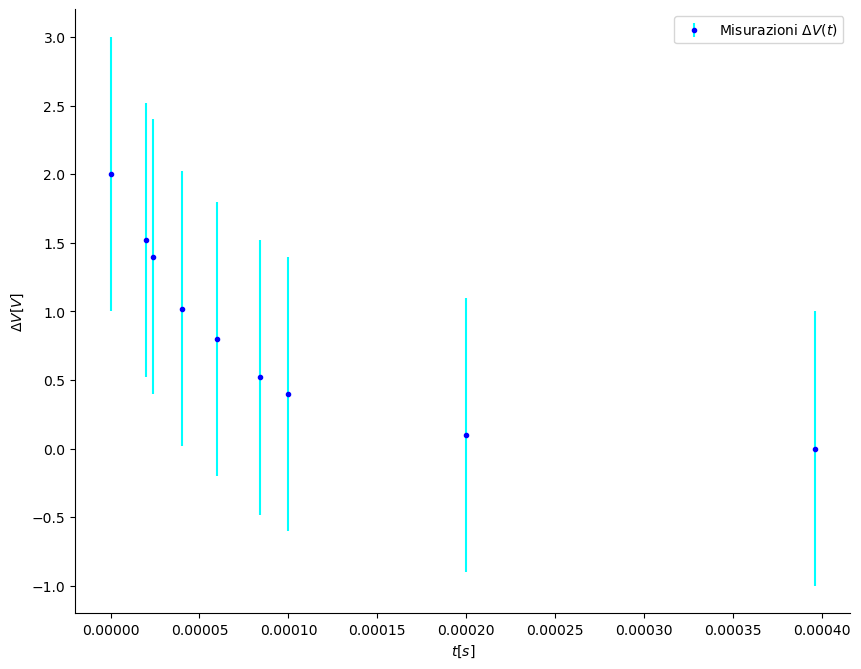

In [9]:
fig = scatterplot_errorbar (t_1, V_1, np.ones(len(t_1)), 
                            'Misurazioni $\Delta V(t)$', 
                            '$t [s]$',  
                            '$\Delta V [V]$', 
                            'Graphs/Graph_ScatterPlot1.png', 
                            resolution = 100, save=True)

## Fit Esponenziale

In [10]:
dt_1      = t_1[:-1]-t_1[-1]
dV_1      = V_1[:-1]-V_1[-1]
U_dV_1    = 0.5*100*(10**(-3))*np.ones(len(dV_1))
logdV_1   = np.log(dV_1)
U_logdV_1 = U_dV_1/dV_1

U_logdV_1

array([0.025     , 0.03289474, 0.03571429, 0.04901961, 0.0625    ,
       0.09615385, 0.125     , 0.5       ])

In [11]:
#def linearfit_plot (x, y, u_y, m, c, u_m, u_c, )

In [17]:
def LinearFit_plot (x, y, w_y,  ldata, lplot, xl, yl, path, size=(10,8), n_ax=111, resolution=100, save=True):
    fig = plt.figure (figsize=size, dpi=resolution)  
    
    E_m, U_m, E_c, U_c, COV_mc, chi2_ev, rho, res = Linear_Fit (x, y, w_y)
    ax = plt.subplot(n_ax)

    ax.errorbar ( x, y, yerr = w_y,
                  linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
                  label = ldata)

    #Curva di Regressione
    xline  = np.linspace ( np.min(x), np.max(x), 1000)
    yline  = y_lin(xline, E_m, E_c)
    
    ax.plot ( xline, yline, 
              linestyle = '--', color = 'red',
              label = lplot)
    #Retta di estrapolazione
    #ax.vlines (np.min(dt_1), 0, np.exp(E_m*np.min(dt_1)+ E_c), 
    #           linestyle = 'dashdot', color= 'black', alpha = 0.5)
    
    #ax.set_xlim(0,10)
    ax.xaxis.set_label_text(xl)
    ax.yaxis.set_label_text(yl) 
    #Customization
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    #ax.spines['left'].set_position('zero')
    ax.legend(loc='best')
    
    if (save):
        fig = plt.savefig(path)
    
    return fig

E_m = -1.587e+04
VAR_m = 4.526e+05
U_m = 672.8
E_c = -5.578
VAR_c = 0.06403
U_c = 0.253
chi2 = 2.702
rho_mc = 0.9981



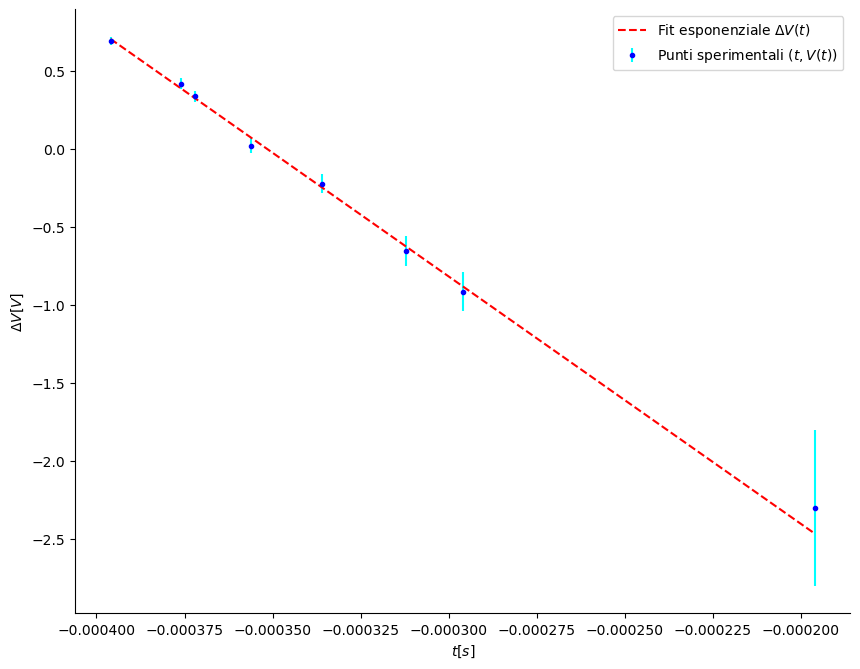

In [18]:
#m, um, c, uc, COV_mc, chi2_ev = Linear_Fit (dt_1, logdV_1, U_logdV_1)
fig = LinearFit_plot (dt_1, logdV_1, U_logdV_1,
           'Punti sperimentali $(t, V(t))$', 
           'Fit esponenziale $\Delta V(t)$',
           '$t [s]$',
           '$\Delta V [V]$', 
           "Graphs/boh.png")

In [ ]:
fig = plt.figure (figsize=(20,10), dpi=100)  
#####################
# Fit Esponeniziale #
#####################
ax = plt.subplot(121)
E_m[0], U_m[0], E_c[0], U_c[0], COV_mc[0], chi2_ev[0] = Linear_Fit (dt_1, logdV_1, U_logdV_1)

ax.errorbar ( dt_1, dV_1, yerr = U_dV_1,
              linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
              label = 'Punti sperimentali $(t, V(t))$')

#Curva di Regressione
xline  = np.linspace ( np.min(dt_1), np.max(dt_1), 1000)
yline  = np.exp(y_lin(xline, E_m[0],E_c[0]))
    
ax.plot ( xline, yline, 
          linestyle = '--', color = 'red',
          label = 'Fit esponenziale $\Delta V(t)$')
#Retta di estrapolazione
#ax.vlines (np.min(dt_1), 0, np.exp(E_m*np.min(dt_1)+ E_c), 
#           linestyle = 'dashdot', color= 'black', alpha = 0.5)
    
#ax.set_xlim(0,10)
ax.xaxis.set_label_text('$t [s]$')
ax.yaxis.set_label_text('$\Delta V [V]$') 
#Customization
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
#ax.spines['left'].set_position('zero')
ax.legend(loc='best')

ax = plt.subplot (1,2,2)
lin_fit(dt_1[:7], logdV_1[:7], U_logdV_1[:7], xlabel="t [s]", ylabel="log($\Delta V/V$) [ad]", verbose=False, plot=True, setrange=False)

fig = plt.savefig ("Graphs/Graph_ExpFit1.png")

In [ ]:
sigma_th = s_th (dt_1, logdV_1, E_m[0], E_c[0])
np.exp(sigma_th)

## $\tau$

In [ ]:
E_Tau_1 = -1/E_m[0]
U_Tau_1 = (E_Tau_1**2)*U_m[0]

E_Tau_1*10**6, U_Tau_1*10**6

In [ ]:
lin_fit(dt_1[:7], logdV_1[:7], U_logdV_1[:7], xlabel="t [s]", ylabel="log($\Delta V$) [V]", verbose=False, plot=True, setrange=False)

# Parte 2

## Dati

In [ ]:
###########
# Parte 2 #
###########
V_2 = np.array([8.4, 7.36, 6.40, 5.36, 4.56, 3.84, 3.28, 2.80, 2.40, 2.00, 1.84])
t_2 = np.array([0,  7.6, 17.6, 27.6, 37.6, 47.6, 57.6, 67.6, 77.6, 87.6, 97.6])*(10**(-6))

## Scatterplot

In [ ]:
fig = plt.figure(figsize = (10,8), dpi = 100)
ax = plt.subplot(1,1,1)
#Scatter 
ax.errorbar (t_2, V_2, yerr = np.ones(len(t_2)), 
             linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
             label = 'Misurazioni'+ ' $\Delta V(t)$')
#Axes
ax.yaxis.set_label_text('$\delta V [V]$')
ax.xaxis.set_label_text('$t [s]$')
#Customization
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.legend(loc='best')

fig = plt.savefig("Graphs/Graph_ScatterPlot2.png")

## Fit Esponenziale

In [ ]:
dt_2 = t_2[:-1]
dV_2 = V_2[:-1]
U_dV_2 = 0.5*400*(10**(-3))*np.ones(len(dV_2))
logdV_2 = np.log(dV_2)
U_logdV_2 = U_dV_2/dV_2

dt_2, dV_2, logdV_2, U_logdV_2

In [ ]:
fig = plt.figure (figsize=(20,10), dpi=100)  
#####################
# Fit Esponeniziale #
#####################
ax = plt.subplot(1,2,1)
E_m[1], U_m[1], E_c[1], U_c[1], COV_mc[1], chi2_ev[1] = Linear_Fit (dt_2, logdV_2, U_logdV_2)

ax.errorbar ( dt_2, dV_2, yerr = U_dV_2,
              linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
              label = 'Punti sperimentali $(t, V(t))$')

#Curva di Regressione
xline  = np.linspace ( np.min(dt_2), np.max(dt_2), 1000)
yline  = np.exp(E_m[1]*xline + E_c[1])
    
ax.plot ( xline, yline, 
          linestyle = '--', color = 'red',
          label = 'Fit esponenziale $\Delta V(t)$')
#Retta di estrapolazione
#ax.vlines (np.min(dt_1), 0, np.exp(E_m*np.min(dt_1)+ E_c), 
#           linestyle = 'dashdot', color= 'black', alpha = 0.5)
    
#ax.set_xlim(0,10)
ax.xaxis.set_label_text('$t [s]$')
ax.yaxis.set_label_text('$\Delta V [V]$') 
#Customization
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
#ax.spines['left'].set_position('zero')
ax.legend(loc='best')

ax = plt.subplot (1,2,2)
lin_fit(dt_2, logdV_2, U_logdV_2, xlabel="t [s]", ylabel="log($\Delta V/V$) [ad]", verbose=False, plot=True, setrange=False)

fig = plt.savefig ("Graphs/Graph_ExpFit2.png")

## $\tau$

In [ ]:
E_Tau_2 = -1/E_m[1]
U_Tau_2 = (E_Tau_2**2)*U_m[1]

E_Tau_2*10**6, U_Tau_2*10**6

# Parte 3

## Dati

In [ ]:
###########
# Parte 3 #
###########
V_3 = np.array([0, 800*(10**(-3)), 1.84,2.56, 3.04, 3.44, 3.68, 3.84])
t_3 = np.array([0, 6, 16, 26, 36, 46, 56, 66])*(10**(-6))

## Scatterplot

In [ ]:
fig = plt.figure(figsize = (10,8), dpi = 100)
ax = plt.subplot(1,1,1)
#Scatter 
ax.errorbar (t_3, V_3, yerr = np.ones(len(t_3)), 
             linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
             label = 'Misurazioni'+ ' $\Delta V(t)$')
#Axes
ax.yaxis.set_label_text('$V [V]$')
ax.xaxis.set_label_text('$t [s]$')
#Customization
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.legend(loc='best')

fig = plt.savefig("Graphs/Graph_ScatterPlot3.png")

## Fit Esponenziale

In [ ]:
dt_3 = t_3[1:-2]
dV_3 = V_3[-1]- V_3[1:-2]
U_dV_3 = 200*(10**(-3))*np.ones(len(dV_3))
logdV_3 = np.log(dV_3)
U_logdV_3 = U_dV_3/dV_3

dt_3, dV_3, logdV_3, U_logdV_3,

In [ ]:
fig = plt.figure (figsize=(20,10), dpi=400)  
#####################
# Fit Esponeniziale #
#####################
ax = plt.subplot(1,2,1)
E_m[2], U_m[2], E_c[2], U_c[2], COV_mc[2], chi2_ev[2] = Linear_Fit (dt_3, logdV_3, U_logdV_3)

ax.errorbar ( dt_3, V_3[-1]-dV_3, yerr = U_dV_3,
              linestyle = ' ', ecolor = 'cyan', fmt = '.', color = 'blue',
              label = 'Punti sperimentali $(t, \Delta V)$')

#Curva di Regressione
xline  = np.linspace ( np.min(dt_3), np.max(dt_3), 1000)
yline  = V_3[-1] - np.exp(E_m[2]*xline + E_c[2])
    
ax.plot ( xline, yline, 
          linestyle = '--', color = 'red',
          label = 'Fit esponenziale $\Delta V(t)$')
#Retta di estrapolazione
#ax.vlines (np.min(dt_1), 0, np.exp(E_m*np.min(dt_1)+ E_c), 
#           linestyle = 'dashdot', color= 'black', alpha = 0.5)
    
#ax.set_xlim(0,10)
ax.xaxis.set_label_text('$t [s]$')
ax.yaxis.set_label_text('$\Delta V_{(3)} [V]$') 
#Customization
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
#ax.spines['left'].set_position('zero')
ax.legend(loc='best')

ax = plt.subplot(1,2,2)

lin_fit(dt_3, logdV_3, U_logdV_3, xlabel="t [s]", ylabel="log($\Delta V/V$) [ad]", verbose=False, plot=True, setrange=False)

fig = plt.savefig ("Graphs/Graph_ExpFit3.png")
E_m[2], U_m[2], E_c[2], U_c[2]

## $\tau$

In [ ]:
E_Tau_3 = -1/E_m[2]
U_Tau_3 = (E_Tau_3**2)*U_m[2]

E_Tau_3*10**6, U_Tau_3*10**6

# Conclusioni e z

In [ ]:
R = 2.7*(10**3)
C = 22*(10**(-9))

tau1_th  = R*C
tau2_th = R*C/2

tau1_th, tau2_th

In [ ]:
z_1 = np.abs(E_Tau_1-tau1_th)/U_Tau_1
z_2 = np.abs(E_Tau_2-tau1_th)/U_Tau_2
z_3 = np.abs(E_Tau_3-tau2_th)/U_Tau_3

z_1, z_2, z_3